<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

This notebook is from Winter 2022. 
It uses the court data we scraped in October 2021 to model drug crime defelonization policy in VA.

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from shell_compartment import ShellCompartment
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [3]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../../state/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv',
        index_col=0
    ) for i in range(8)
])

C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3785763279.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3785763279.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3785763279.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3785763279.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3785763279.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3785763279.py:2: DtypeWarning

In [4]:
print(sdc_data['Charge Type'].isnull().sum() / len(sdc_data))
sdc_data = sdc_data[sdc_data['Charge Type'].notnull()]

0.0004171301446051168


In [5]:
missing_class_factor = len(sdc_data) / sdc_data.Class.notnull().sum()
sdc_data = sdc_data[sdc_data.Class.notnull()]
missing_class_factor

1.5925273967205706

In [6]:
class_breakdown = sdc_data[sdc_data.crime_type == 'DRUG_POSSESSION'].groupby('Class').count().max(axis=1)
class_breakdown

Class
1     2974
2      691
3       99
4       46
5    51029
6      895
O    12014
U    20396
dtype: int64

In [7]:
sdc_data.loc[sdc_data['Charge Type'] == 'Felony', 'Charge Type'] = 'F'
sdc_data.loc[sdc_data['Charge Type'] == 'Misdemeanor', 'Charge Type'] = 'M'
sdc_data['crime_class'] = sdc_data['Charge Type'] + sdc_data.Class

In [8]:
# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching

scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month
sorted_data = sorted_data[(sorted_data.time_step > -108) & (sorted_data.time_step <= 33)]

# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'crime_type', 'crime_class']).count()[['Address']].reset_index().rename(
    {'Address': 'total_population', 'crime_class': 'crime'}, axis=1
)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor * missing_class_factor
outflows_data.time_step = outflows_data.time_step.astype('int64')
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\34279916.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)


time_step crime_type crime  total_population compartment outflow_to
0       -107      ARSON    F4          2.424769    pretrial     prison
1       -107      ARSON    F5          4.849538    pretrial     prison
2       -107      ARSON    FU          7.274306    pretrial     prison
3       -107    ASSAULT    F2         21.822919    pretrial     prison
4       -107    ASSAULT    F3         72.743063    pretrial     prison

C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\409657989.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  outflows_data.groupby('time_step').sum().plot(ylim=[0,3000])


<Axes: xlabel='time_step'>

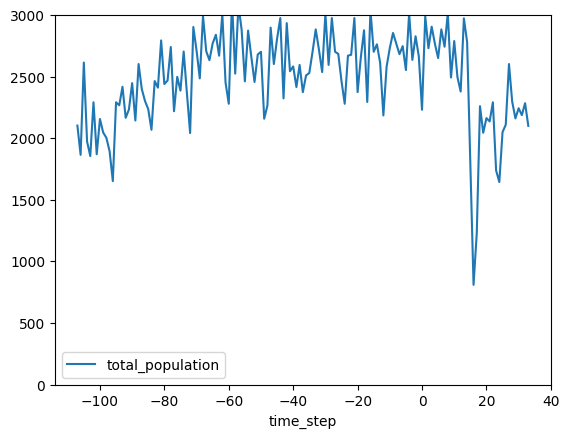

In [9]:
outflows_data.groupby('time_step').sum().plot(ylim=[0,3000])

In [10]:
# Create transitions datta
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'crime_type', 'crime_class'
]).count()[['Address']].reset_index().rename({'Address': 'total_population', 'crime_class': 'crime'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# add release transitions as well

# taken from here (https://vadoc.virginia.gov/media/1681/vadoc-recidivism-re-arrest-rates-report-2016.pdf)
RECIDIVISM_BY_CRIME_TYPE = {
    'ARSON': 0.203,
    'ASSAULT': 0.246,
    'BURGLARY': 0.296,
    'CAPITAL_MURDER': 0.073,
    'CONSPIRACY': 0.263,
    'DRUG_OTHER': 0.212,
    'DRUG_POSSESSION': 0.239,
    'DRUG_SALE': 0.193,
    'DWI': 0.184,
    'FIRST_DEGREE_MURDER': 0.073,
    'KIDNAPPING': 0.146,
    'LARCENY': 0.284,
    'MANSLAUGHTER': 0.105,
    'OTHER_MURDER': 0.073,
    'RAPE': 0.226,
    'ROBBERY': 0.206,
    'SECOND_DEGREE_MURDER': 0.073,
    'SEX_OFFENSE': 0.25,        
    'WEAPON': 0.209
}

# taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
    6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6,
    12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6,
    18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5,
    24: (15.0 + 15.3 + 15.0 + 15.6) / 4,
    36: (22.4 + 23.4 + 23.1 + 23.9) / 4
}
recidivism_transitions = pd.DataFrame({
    'compartment': ['release'] * 36,
    'outflow_to': ['prison'] * 36,
    'compartment_duration': range(1, 37),
    'total_population': (
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
    )
})

crime_classes = outflows_data.crime.unique()

for crime in crime_types:
    for crime_class in crime_classes:
        crime_recidivism = recidivism_transitions.copy()
        total_recidivism = sum(RECIDIVISM_BY_MONTHS_SINCE_RELEASE.values())
        crime_specific_total_recidivism = RECIDIVISM_BY_CRIME_TYPE[crime]
        crime_recidivism.total_population *= crime_specific_total_recidivism / total_recidivism
        crime_recidivism = crime_recidivism.append({
            'compartment_duration': 36,
            'total_population': 1 - crime_specific_total_recidivism,
            'compartment': 'release',
            'outflow_to': 'release_full',
        }, ignore_index=True)
        crime_recidivism['crime_type'] = crime
        crime_recidivism['crime'] = crime_class

        transitions_data = transitions_data.append(crime_recidivism)

        # adjust outflows so we're not double counting recidivism
        outflows_data.loc[
            (outflows_data.crime_type == crime) & (outflows_data.crime == crime_class), 'total_population'
        ] /= 1 + crime_specific_total_recidivism


crime_class_combination = []
for crime_class in crime_classes:
    crime_class_combination += [crime_class] * len(crime_types)
    

transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * len(crime_types) * len(crime_classes),
    'total_population': [1] * len(crime_types) * len(crime_classes),
    'compartment': ['release_full'] * len(crime_types) * len(crime_classes),
    'outflow_to': ['release_full'] * len(crime_types) * len(crime_classes),
    'crime_type': crime_types * len(crime_classes),
    'crime': crime_class_combination
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3552797437.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crime_recidivism = crime_recidivism.append({
C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3552797437.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_data = transitions_data.append(crime_recidivism)
C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3552797437.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crime_recidivism = crime_recidivism.append({
C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\3552797437.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_data = transitions_data.a

compartment_duration crime_type crime  total_population compartment  \
0                   1.0      ARSON    F1               2.0      prison   
1                   1.0      ARSON    F3               3.0      prison   
2                   1.0      ARSON    F4              13.0      prison   
3                   1.0      ARSON    F5              40.0      prison   
4                   1.0      ARSON    F6               1.0      prison   

  outflow_to  
0    release  
1    release  
2    release  
3    release  
4    release

In [34]:
transitions_data[transitions_data["outflow_to"] == "prison"]

compartment_duration  cohort_portion compartment outflow_to  \
4118                   1.0        0.000940     release     prison   
4119                   2.0        0.000940     release     prison   
4120                   3.0        0.000940     release     prison   
4121                   4.0        0.000940     release     prison   
4122                   5.0        0.000940     release     prison   
4123                   6.0        0.000940     release     prison   
4124                   7.0        0.003503     release     prison   
4125                   8.0        0.003503     release     prison   
4126                   9.0        0.003503     release     prison   
4127                  10.0        0.003503     release     prison   
4128                  11.0        0.003503     release     prison   
4129                  12.0        0.003503     release     prison   
4130                  13.0        0.007250     release     prison   
4131                  14.0        0.007250     release     prison   
4132                  15.0        0.007250     release     prison   
4133                  16.0        0.007250     release     prison   
4134                  17.0        0.007250     release     prison   
4135                  18.0        0.007250     release     prison   
4136                  19.0        0.011150     release     prison   
4137                  20.0        0.011150     release     prison   
4138                  21.0        0.011150     release     prison   
4139                  22.0        0.011150     release     prison   
4140                  23.0        0.011150     release     prison   
4141                  24.0        0.011150     release     prison   
4142                  25.0        0.008495     release     prison   
4143                  26.0        0.008495     release     prison   
4144                  27.0        0.008495     release     prison   
4145                  28.0        0.008495     release     prison   
4146                  29.0        0.008495     release     prison   
4147                  30.0        0.008495     release     prison   
4148                  31.0        0.008495     release     prison   
4149                  32.0        0.008495     release     prison   
4150                  33.0        0.008495     release     prison   
4151                  34.0        0.008495     release     prison   
4152                  35.0        0.008495     release     prison   
4153                  36.0        0.008495     release     prison   
4155                   1.0        0.000940     release     prison   
4156                   2.0        0.000940     release     prison   
4157                   3.0        0.000940     release     prison   
4158                   4.0        0.000940     release     prison   
4159                   5.0        0.000940     release     prison   
4160                   6.0        0.000940     release     prison   
4161                   7.0        0.003503     release     prison   
4162                   8.0        0.003503     release     prison   
4163                   9.0        0.003503     release     prison   
4164                  10.0        0.003503     release     prison   
4165                  11.0        0.003503     release     prison   
4166                  12.0        0.003503     release     prison   
4167                  13.0        0.007250     release     prison   
4168                  14.0        0.007250     release     prison   
4169                  15.0        0.007250     release     prison   
4170                  16.0        0.007250     release     prison   
4171                  17.0        0.007250     release     prison   
4172                  18.0        0.007250     release     prison   
4173                  19.0        0.011150     release     prison   
4174                  20.0        0.011150     release     prison   
4175                  21.0        0.011150     release     prison   
4176

In [11]:
# Total population data

total_pop = {
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
    
}

total_population_data = pd.DataFrame({
    'time_step': range(34),
    'total_population': total_pop[2019] + total_pop[2020] + total_pop[2021]
})
total_population_data['compartment'] = 'prison'
total_population_data.total_population = total_population_data.total_population.astype(float)


In [12]:
population_data = total_population_data.rename({'total_population':'compartment_population'}, axis=1)

In [13]:
# REDUCE TO JUST DRUG POSSESSION CUZ THAT'S ALL WE CARE ABOUT

population_breakdown = transitions_data.copy()
population_breakdown['weighted_population'] = \
    population_breakdown.total_population * population_breakdown.compartment_duration
population_breakdown = population_breakdown.groupby('crime_type').sum()
population_breakdown = \
    population_breakdown.weighted_population / population_breakdown.weighted_population.sum()
drug_possession_fraction = population_breakdown.loc['DRUG_POSSESSION']
population_breakdown

C:\Users\isaac\AppData\Local\Temp\ipykernel_19416\2994942192.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  population_breakdown = population_breakdown.groupby('crime_type').sum()


crime_type
ARSON                   0.005752
ASSAULT                 0.141264
BURGLARY                0.062296
CAPITAL_MURDER          0.008937
CONSPIRACY              0.012405
DRUG_OTHER              0.056850
DRUG_POSSESSION         0.097422
DRUG_SALE               0.099420
DWI                     0.025575
FIRST_DEGREE_MURDER     0.025556
KIDNAPPING              0.015822
LARCENY                 0.122945
MANSLAUGHTER            0.004106
OTHER_MURDER            0.067900
RAPE                    0.097896
ROBBERY                 0.068418
SECOND_DEGREE_MURDER    0.003556
SEX_OFFENSE             0.010227
WEAPON                  0.073656
Name: weighted_population, dtype: float64

In [14]:
outflows_data = outflows_data[outflows_data.crime_type == 'DRUG_POSSESSION']
transitions_data = transitions_data[
    (transitions_data.crime_type == 'DRUG_POSSESSION') & 
    transitions_data.crime.apply(lambda x: x not in ['InfractionU', 'CivilU', 'M3'])] # add this because there's on drug possession data but that group was added to recidivism data
total_population_data.total_population *= drug_possession_fraction

In [15]:
transitions_data = transitions_data.rename({'total_population':'cohort_portion'}, axis=1)
transitions_data['simulation_group'] = transitions_data['crime_type'] + transitions_data['crime']
transitions_data = transitions_data.drop(['crime_type', 'crime'], axis=1)

In [16]:
# admissions data (2023 update)
admissions_data = outflows_data.rename(
    {'total_population':'cohort_population', 'outflow_to':'admission_to'},
    axis=1
)
admissions_data['simulation_group'] = admissions_data['crime_type'] + admissions_data['crime']
admissions_data = admissions_data.drop(['crime_type', 'crime'], axis=1)

In [17]:
import pandas_gbq

pandas_gbq.context.credentials
#dir(pandas_gbq.context.credentials)

In [18]:
admissions_data

time_step  cohort_population compartment admission_to   simulation_group
20         -107           1.957037    pretrial       prison  DRUG_POSSESSIONF2
21         -107           3.914074    pretrial       prison  DRUG_POSSESSIONF3
22         -107         140.906659    pretrial       prison  DRUG_POSSESSIONF5
23         -107           3.914074    pretrial       prison  DRUG_POSSESSIONF6
24         -107          88.066662    pretrial       prison  DRUG_POSSESSIONFU
...         ...                ...         ...          ...                ...
8862         32          99.808884    pretrial       prison  DRUG_POSSESSIONFU
8916         33         193.746657    pretrial       prison  DRUG_POSSESSIONF5
8917         33           1.957037    pretrial       prison  DRUG_POSSESSIONF6
8918         33          84.152588    pretrial       prison  DRUG_POSSESSIONFU
8919         33           1.957037    pretrial       prison  DRUG_POSSESSIONM1

[695 rows x 5 columns]

In [32]:

released = transitions_data[(transitions_data['simulation_group'] == 'DRUG_POSSESSIONF1') & (transitions_data['outflow_to'] == 'release')]['cohort_portion'].sum()
intake = transitions_data[(transitions_data['simulation_group'] == 'DRUG_POSSESSIONF1') & (transitions_data['outflow_to'] == 'prison')]['cohort_portion'].sum()

transitions_data[(transitions_data['simulation_group'] == 'DRUG_POSSESSIONF1') & (transitions_data['outflow_to'] == 'prison')]

compartment_duration  cohort_portion compartment outflow_to  \
4451                   1.0        0.000940     release     prison   
4452                   2.0        0.000940     release     prison   
4453                   3.0        0.000940     release     prison   
4454                   4.0        0.000940     release     prison   
4455                   5.0        0.000940     release     prison   
4456                   6.0        0.000940     release     prison   
4457                   7.0        0.003503     release     prison   
4458                   8.0        0.003503     release     prison   
4459                   9.0        0.003503     release     prison   
4460                  10.0        0.003503     release     prison   
4461                  11.0        0.003503     release     prison   
4462                  12.0        0.003503     release     prison   
4463                  13.0        0.007250     release     prison   
4464                  14.0        0.007250     release     prison   
4465                  15.0        0.007250     release     prison   
4466                  16.0        0.007250     release     prison   
4467                  17.0        0.007250     release     prison   
4468                  18.0        0.007250     release     prison   
4469                  19.0        0.011150     release     prison   
4470                  20.0        0.011150     release     prison   
4471                  21.0        0.011150     release     prison   
4472                  22.0        0.011150     release     prison   
4473                  23.0        0.011150     release     prison   
4474                  24.0        0.011150     release     prison   
4475                  25.0        0.008495     release     prison   
4476                  26.0        0.008495     release     prison   
4477                  27.0        0.008495     release     prison   
4478                  28.0        0.008495     release     prison   
4479                  29.0        0.008495     release     prison   
4480                  30.0        0.008495     release     prison   
4481                  31.0        0.008495     release     prison   
4482                  32.0        0.008495     release     prison   
4483                  33.0        0.008495     release     prison   
4484                  34.0        0.008495     release     prison   
4485                  35.0        0.008495     release     prison   
4486                  36.0        0.008495     release     prison   

       simulation_group  
4451  DRUG_POSSESSIONF1  
4452  DRUG_POSSESSIONF1  
4453  DRUG_POSSESSIONF1  
4454  DRUG_POSSESSIONF1  
4455  DRUG_POSSESSIONF1  
4456  DRUG_POSSESSIONF1  
4457  DRUG_POSSESSIONF1  
4458  DRUG_POSSESSIONF1  
4459  DRUG_POSSESSIONF1  
4460  DRUG_POSSESSIONF1  
4461  DRUG_POSSESSIONF1  
4462  DRUG_POSSESSIONF1  
4463  DRUG_POSSESSIONF1  
4464  DRUG_POSSESSIONF1  
4465  DRUG_POSSESSIONF1  
4466  DRUG_POSSESSIONF1  
4467  DRUG_POSSESSIONF1  
4468  DRUG_POSSESSIONF1  
4469  DRUG_POSSESSIONF1  
4470  DRUG_POSSESSIONF1  
4471  DRUG_POSSESSIONF1  
4472  DRUG_POSSESSIONF1  
4473  DRUG_POSSESSIONF1  
4474  DRUG_POSSESSIONF1  
4475  DRUG_POSSESSIONF1  
4476  DRUG_POSSESSIONF1  
4477  DRUG_POSSESSIONF1  
4478  DRUG_POSSESSIONF1  
4479  DRUG_POSSESSIONF1  
4480  DRUG_POSSESSIONF1  
4481  DRUG_POSSESSIONF1  
4482  DRUG_POSSESSIONF1  
4483  DRUG_POSSESSIONF1  
4484  DRUG_POSSESSIONF1  
4485  DRUG_POSSESSIONF1  
4486  DRUG_POSSESSIONF1

In [20]:
simulation_tag = "va_drug_defelonization"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    admissions_data,
    transitions_data,
    population_data,
    '../../state/VA/2022/policy_configurations/drug_defelonization_model_inputs.yaml',
)

C:\Users\isaac\.virtualenvs\sdc-data-science-iCMpQ41f\lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


# Modeling

In [21]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../../state/VA/2022/policy_configurations/drug_defelonization_model_inputs.yaml'
)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


initialization time:  35.404590368270874


simulation_time:  42.440651178359985


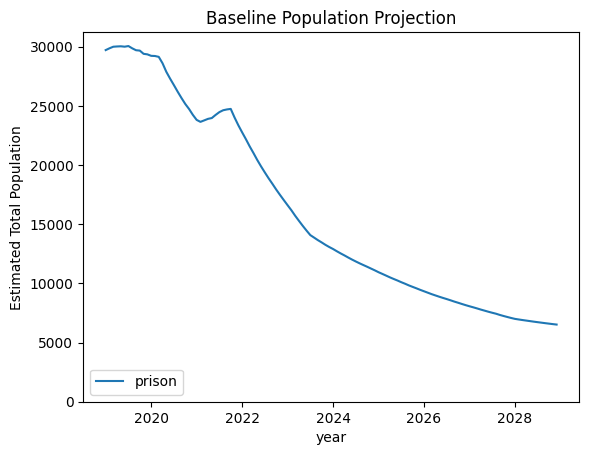

In [22]:
spark_sim.simulate_baseline(['prison'])

ValueError: Axis limits cannot be NaN or Inf

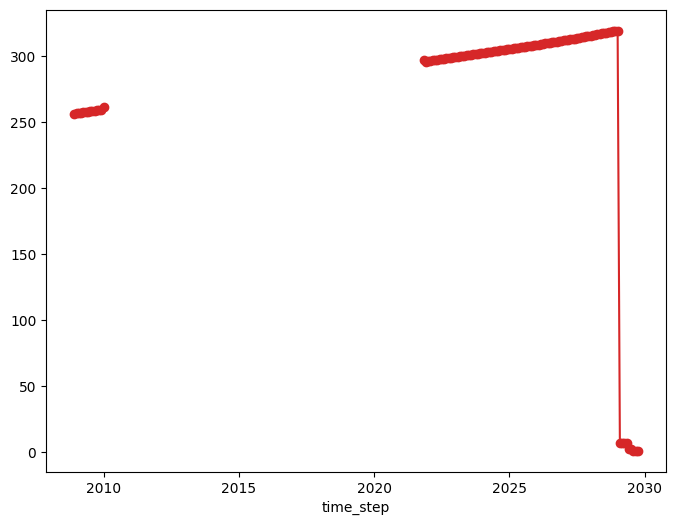

In [23]:
spark_sim.get_arima_output_plots('baseline_projections')

In [24]:
transitions_data.groupby('crime').sum()


KeyError: 'crime'

In [25]:
transitions_data[(transitions_data.crime == 'F5') & (transitions_data.compartment == 'prison')].plot(
    y='total_population',x='compartment_duration',xlim=[None,100]
)

AttributeError: 'DataFrame' object has no attribute 'crime'

In [ ]:
transitions_data[(transitions_data.crime == 'M1') & (transitions_data.compartment == 'prison')].plot(
    y='total_population',x='compartment_duration',xlim=[None, 100]
)

In [ ]:
transitions_data.groupby('simulation_group').count().max(axis=1)

In [ ]:
transitions_data.simulation_group.str.contains('M1').sum()

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

initialization time:  48.48904895782471


/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  (scale_factors[population_disagg_axes] == agg_simulation_attr).all(
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../sh

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  (scale_factors[population_disagg_axes] == agg_simulation_attr).all(
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulatio

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulatio

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulatio

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulatio

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

simulation_time:  42.7492458820343


/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../sh

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  (scale_factors[population_disagg_axes] == agg_simulation_attr).all(
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../sh

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../sh

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../sh

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulatio

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../sh

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  (scale_factors[population_disagg_axes] == agg_simulation_attr).all(
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  (scale_factors[population_disagg_axes] == agg_simulation_attr).all(
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this wa

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulatio

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulatio

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../sh

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulatio

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgroup_populations.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:214: FutureWarning: The default d

simulation_time:  45.36638808250427
0.0


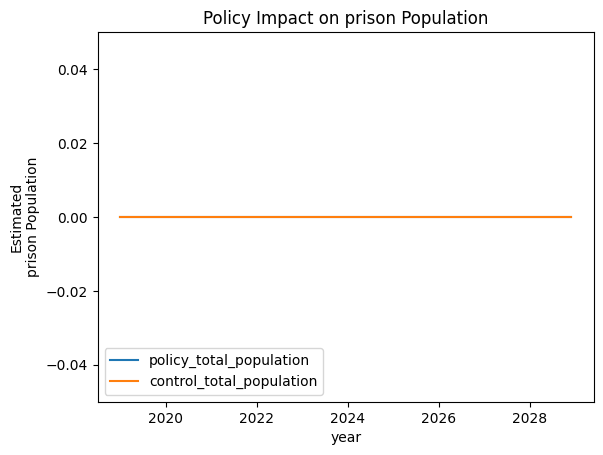

In [ ]:
M1_transitions = transitions_data[(transitions_data.simulation_group.str.contains('M1')) & (transitions_data.compartment == 'prison')]

policy_list = [
    SparkPolicy(
        spark_compartment='prison',
        simulation_group='DRUG_POSSESSIONF5',
        policy_time_step=36,
        apply_retroactive=False,
        alternate_transitions_data=M1_transitions
    )
]

test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [ ]:
simulation_tag = 'drug_defelonization_jan_10'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

In [ ]:
currently_incarcerated = sorted_data[(sorted_data.time_step < 30) & (sorted_data.time_step + sorted_data.compartment_duration > 30)]
len(currently_incarcerated)/len(sorted_data)

In [ ]:
len(currently_incarcerated[(currently_incarcerated.crime_class == 'F5') & 
                           (currently_incarcerated.crime_type == 'DRUG_POSSESSION')]) * scale_factor * missing_class_factor

In [ ]:
sorted_data[(sorted_data.crime_class == 'F5') 
            & (sorted_data.crime_type == 'DRUG_POSSESSION')].compartment_duration.mean()

In [ ]:
sorted_data[(sorted_data.crime_class == 'M1') 
            & (sorted_data.crime_type == 'DRUG_POSSESSION')].compartment_duration.mean()